# QUESTION: 

The Rain in Australia dataset contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:

![Photo](11.png "Title")

As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

# Downloading the Data

The dataset is available at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package .

We'll use the opendatasets library to download the data from Kaggle directly within Jupyter.


In [2]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

In [3]:
raw_df = pd.read_csv('weatherAUS.csv')
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
raw_df.dropna(subset = ['RainTomorrow'],inplace=True)

# Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

    1. Create a train/test/validation split
    2. Identify input and target columns
    3. Identify numeric and categorical columns
    4. Impute (fill) missing numeric values
    5. Scale numeric values to the (0,1) range
    6. Encode categorical columns to one-hot vectors

# Training, Validation and Test Sets

<AxesSubplot:title={'center':'No. of rows per year'}, xlabel='Date', ylabel='count'>

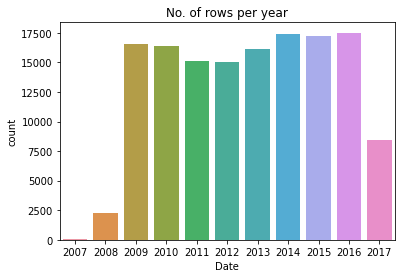

In [6]:
plt.title("No. of rows per year")
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year)

In [7]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year<2015]
val_df = raw_df[year==2015]
test_df = raw_df[year>2015]

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(98988, 23)
(17231, 23)
(25974, 23)


# Input and Target Columns

In [8]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [10]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [11]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(numeric_cols)
print(categorical_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [12]:
raw_df.corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.736267,0.104255,0.467261,0.072961,0.177285,0.176005,0.175749,-0.234211,0.005999,-0.451260,-0.461623,0.077625,0.020489,0.901813,0.708865
MaxTemp,0.736267,1.000000,-0.074839,0.588915,0.469967,0.067690,0.014680,0.050800,-0.505432,-0.509270,-0.332293,-0.427279,-0.289865,-0.279053,0.887020,0.984562
Rainfall,0.104255,-0.074839,1.000000,-0.064549,-0.227525,0.133497,0.086816,0.057759,0.223725,0.255312,-0.168085,-0.126728,0.198195,0.171993,0.011477,-0.079178
Evaporation,0.467261,0.588915,-0.064549,1.000000,0.366607,0.203001,0.193936,0.128895,-0.505890,-0.392785,-0.269907,-0.293160,-0.185032,-0.184287,0.545497,0.574275
Sunshine,0.072961,0.469967,-0.227525,0.366607,1.000000,-0.032831,0.008040,0.056012,-0.491603,-0.629122,0.040959,-0.020464,-0.675610,-0.704202,0.291139,0.490180
WindGustSpeed,0.177285,0.067690,0.133497,0.203001,-0.032831,1.000000,0.604837,0.686419,-0.215461,-0.026663,-0.457891,-0.412922,0.071235,0.109088,0.150258,0.032970
WindSpeed9am,0.176005,0.014680,0.086816,0.193936,0.008040,0.604837,1.000000,0.519971,-0.270807,-0.031607,-0.227923,-0.174916,0.024280,0.053584,0.129298,0.005108
WindSpeed3pm,0.175749,0.050800,0.057759,0.128895,0.056012,0.686419,0.519971,1.000000,-0.145942,0.015903,-0.295567,-0.254988,0.052780,0.025269,0.163601,0.028567
Humidity9am,-0.234211,-0.505432,0.223725,-0.505890,-0.491603,-0.215461,-0.270807,-0.145942,1.000000,0.667388,0.139519,0.186955,0.452182,0.358043,-0.472826,-0.499777
Humidity3pm,0.005999,-0.509270,0.255312,-0.392785,-0.629122,-0.026663,-0.031607,0.015903,0.667388,1.000000,-0.027449,0.051840,0.517037,0.523270,-0.221467,-0.557989


# Imputing missing numeric values


In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [14]:
test_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

# Scaling Numeric Features

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols]) 
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [16]:
train_inputs.describe().loc[['min','max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.013233,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0304,0.0,0.0,0.027426,0.005758
max,1.0,1.000000,1.0,0.568276,0.986207,1.0,0.669231,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.000000,0.988484


# Encoding Categorical Data

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False,handle_unknown='ignore').fit(raw_df[categorical_cols])

encoded_cols = list(encoder.get_feature_names(categorical_cols))

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
C:\Users\hirpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

In [18]:
train_inputs.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
count,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,...,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000
mean,0.483557,0.525583,0.006395,0.036934,0.524929,0.265223,0.108470,0.215734,0.686543,0.515015,...,0.064220,0.055239,0.064462,0.069867,0.061715,0.066907,0.020508,0.767790,0.222108,0.010102
std,0.149330,0.132006,0.022845,0.021552,0.200488,0.102531,0.068789,0.101451,0.188738,0.206181,...,0.245146,0.228447,0.245576,0.254924,0.240638,0.249862,0.141729,0.422244,0.415665,0.100001
min,0.000000,0.013233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.377358,0.429112,0.000000,0.026207,0.517241,0.193798,0.053846,0.149425,0.570000,0.370000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.478774,0.514178,0.000000,0.037723,0.525852,0.255814,0.100000,0.218391,0.690000,0.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.591981,0.618147,0.002156,0.038621,0.634483,0.310078,0.146154,0.275862,0.830000,0.650000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.568276,0.986207,1.000000,0.669231,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.


In [19]:
X_train = train_inputs[numeric_cols+encoded_cols]
X_val = val_inputs[numeric_cols+encoded_cols]
X_test = test_inputs[numeric_cols+encoded_cols]

# Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

!["Photo"](12.png "Title")

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.


# Training

We can use DecisionTreeClassifier from sklearn.tree to train a decision tree.


In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

# Evaluation

Let's evaluate the decision tree using the accuracy score.


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_preds = model.predict(X_train)
pd.value_counts(train_preds)

No     76707
Yes    22281
dtype: int64

In [22]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too.

We can make predictions and compute accuracy in one step using model.score


In [23]:
val_preds = model.predict(X_val)

print(accuracy_score(val_targets, val_preds))
print(model.score(X_val, val_targets))

0.7921188555510418
0.7921188555510418


Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "N0".

In [24]:
val_targets.value_counts()/len(val_targets)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.


# Visualization

We can visualize the decision tree learned from the training data.


[Text(2232.0, 951.3000000000001, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(1116.0, 679.5, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439, 11979]'),
 Text(558.0, 407.70000000000005, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538, 7714]'),
 Text(279.0, 135.89999999999998, '\n  (...)  \n'),
 Text(837.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1674.0, 407.70000000000005, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(1395.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1953.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3348.0, 679.5, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]'),
 Text(2790.0, 407.70000000000005, 'WindGustSpeed <= 0.279\ngini = 0.499\nsamples = 9136\nvalue = [4804, 4332]'),
 Text(2511.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3069.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3906.0, 407.70000000000005, 'Rainfall <=

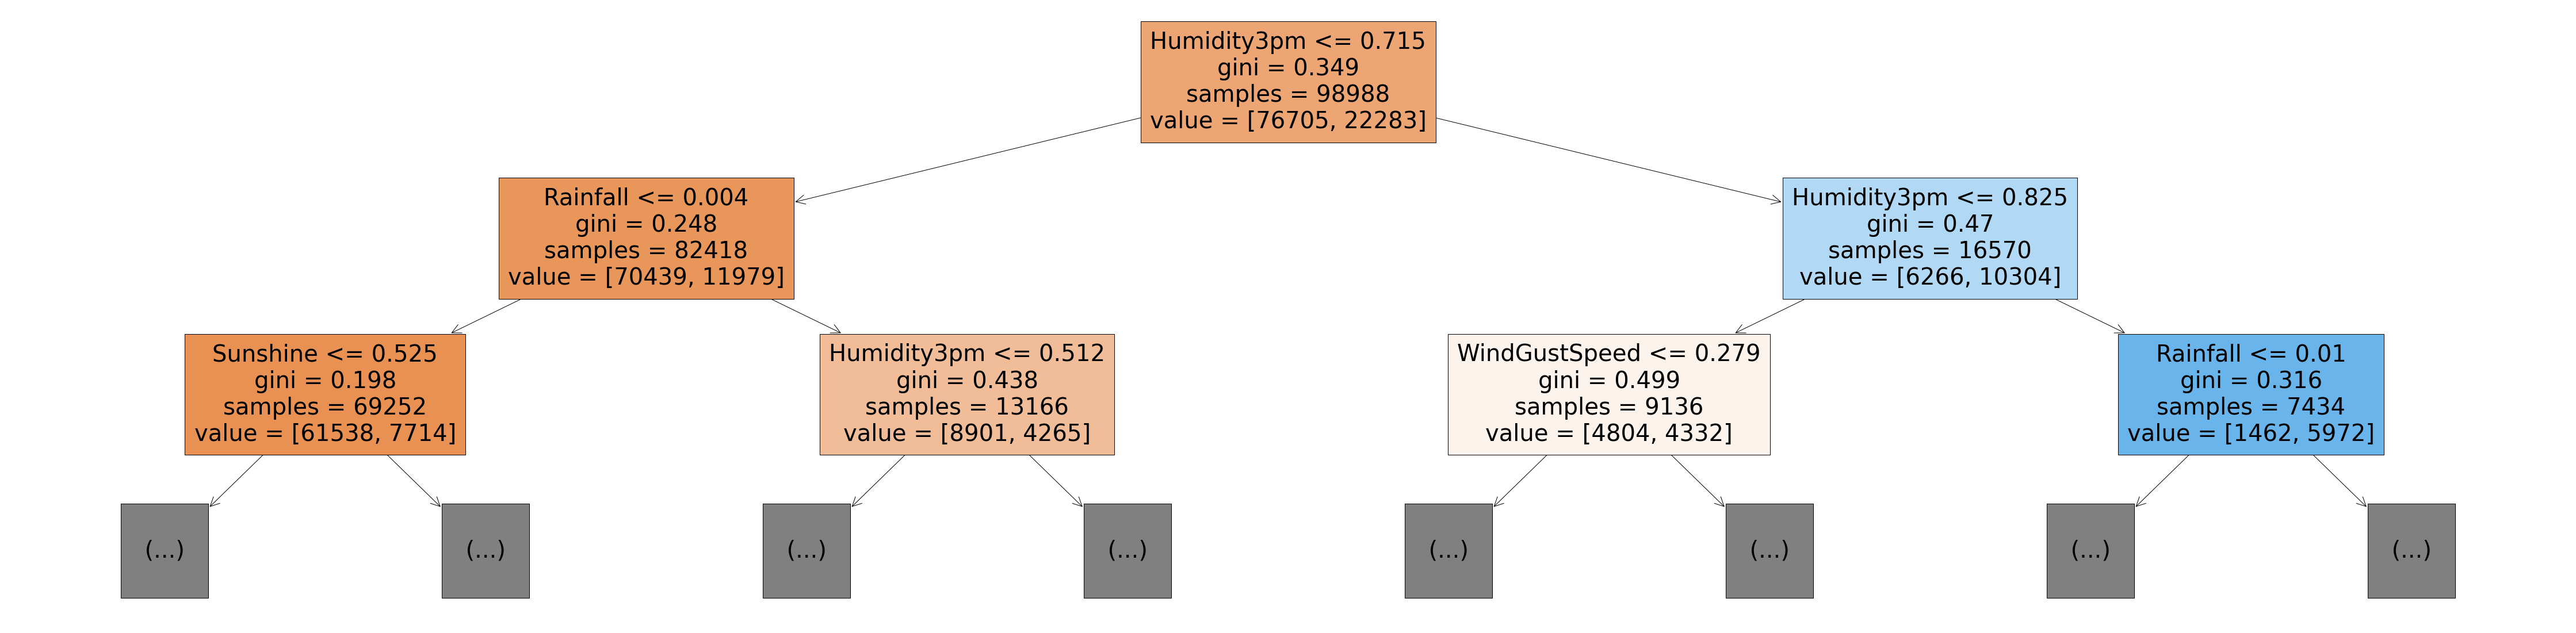

In [25]:
from sklearn.tree import plot_tree, export_text

plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True)

# How a Decision Tree is Created

Note the gini value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0.

!["Photo"](13.png "Title")

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

In [26]:
# Depth of the tree

model.tree_.max_depth

48

We can also display the tree as text, which can be easier to follow for deeper trees.

In [27]:
tree_text = export_text(model,max_depth=10,feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

# Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.


In [28]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [29]:
importance_df = pd.DataFrame({
    'feature' : X_train.columns,
    'importance' : model.feature_importances_
}).sort_values('importance',ascending=False)
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

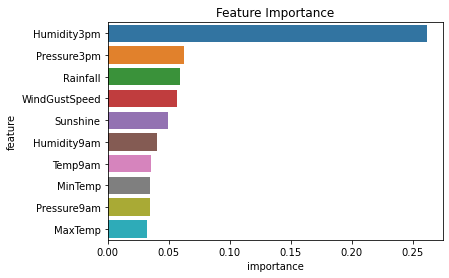

In [30]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10),x='importance',y='feature')

# Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as regularlization.

The DecisionTreeClassifier accepts several arguments, some of which can be modified to reduce overfitting.


These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

# `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [31]:
model = DecisionTreeClassifier(max_depth=3,random_state=42)

model.fit(X_train,train_targets)

print(model.score(X_train,train_targets))
print(model.score(X_val,val_targets))

0.8291308037337859
0.8334397307178921


[Text(2232.0, 951.3000000000001, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]\nclass = No'),
 Text(1116.0, 679.5, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439, 11979]\nclass = No'),
 Text(558.0, 407.70000000000005, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538, 7714]\nclass = No'),
 Text(279.0, 135.89999999999998, 'gini = 0.363\nsamples = 12620\nvalue = [9618, 3002]\nclass = No'),
 Text(837.0, 135.89999999999998, 'gini = 0.153\nsamples = 56632\nvalue = [51920, 4712]\nclass = No'),
 Text(1674.0, 407.70000000000005, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]\nclass = No'),
 Text(1395.0, 135.89999999999998, 'gini = 0.293\nsamples = 4299\nvalue = [3531, 768]\nclass = No'),
 Text(1953.0, 135.89999999999998, 'gini = 0.478\nsamples = 8867\nvalue = [5370, 3497]\nclass = No'),
 Text(3348.0, 679.5, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]\nclass = Yes'),
 Tex

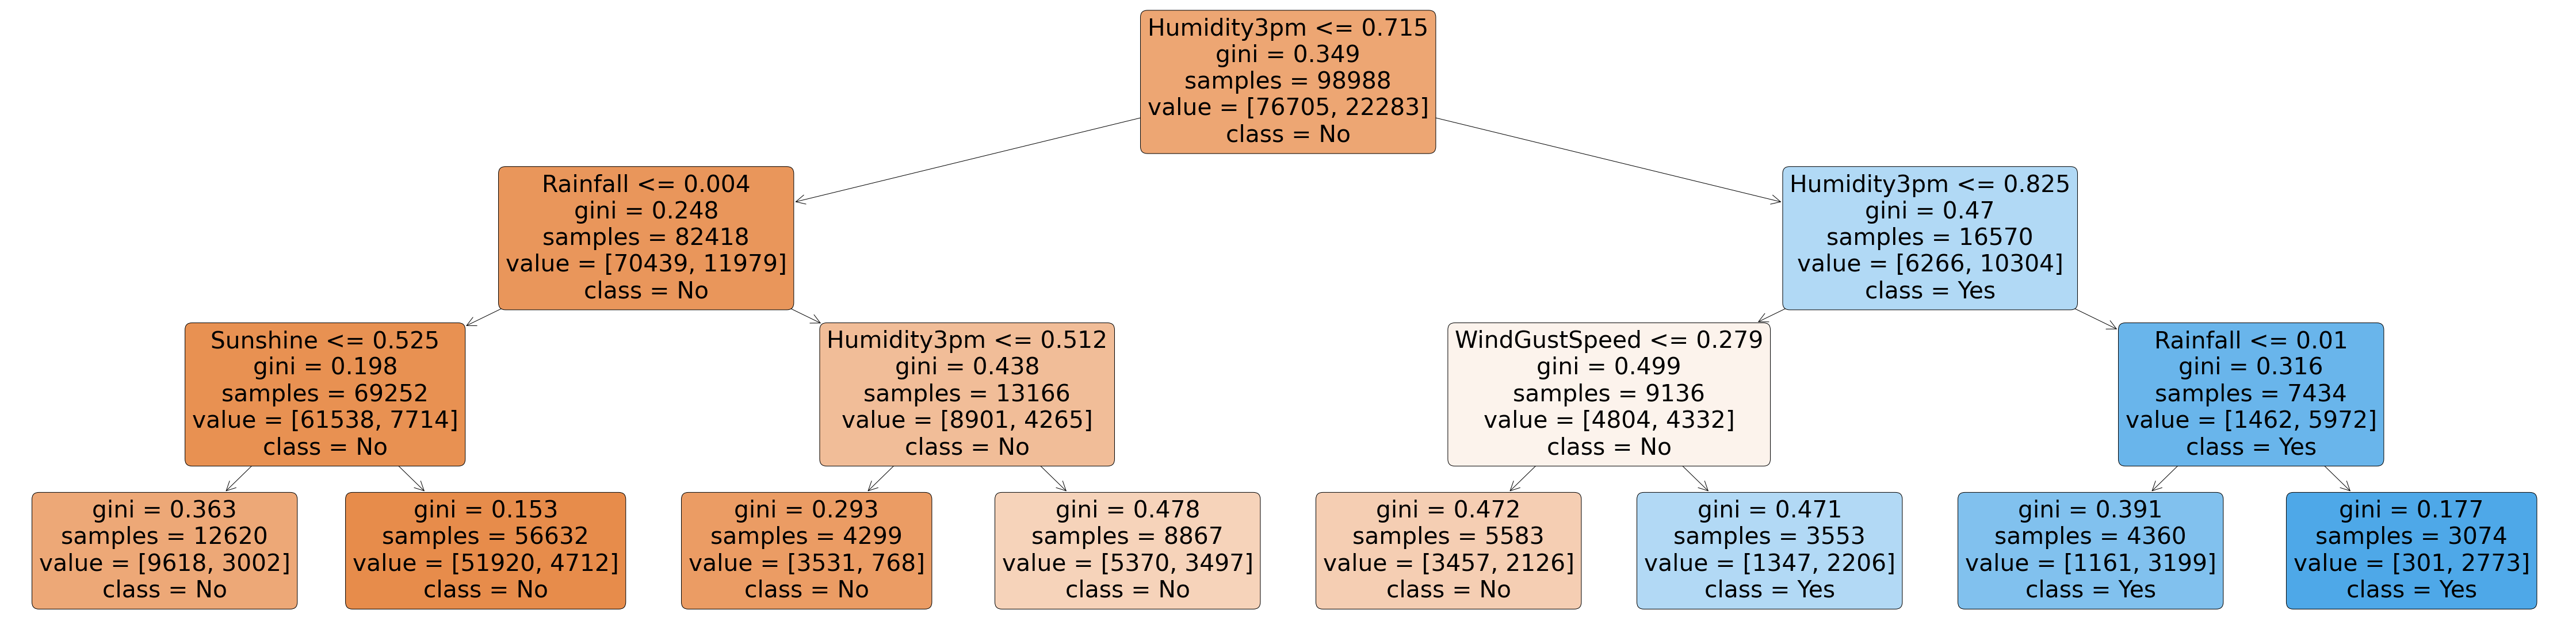

In [32]:
plt.figure(figsize=(80,20))
plot_tree(model,feature_names=X_train.columns,filled=True,rounded=True,class_names=model.classes_)

Let's experiment with different depths using a helper function.

In [33]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md,random_state=42)
    model.fit(X_train,train_targets)
    train_error = 1 - model.score(X_train,train_targets)
    val_error = 1 - model.score(X_val,val_targets)
    return {'Max Depth' : md, "Training Error" : train_error, "Validation Error" : val_error}

In [34]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


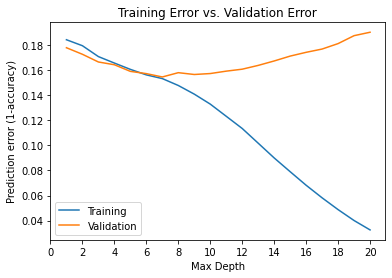

In [35]:
plt.figure()
plt.plot(errors_df['Max Depth'],errors_df['Training Error'])
plt.plot(errors_df['Max Depth'],errors_df['Validation Error'])
plt.title("Training Error vs. Validation Error")
plt.xticks(range(0,21,2))
plt.xlabel('Max Depth')
plt.ylabel('Prediction error (1-accuracy)')
plt.legend(['Training','Validation'])

This is a common pattern you'll see with all machine learning algorithms:

!["Photo"](14.png "Title")

You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [36]:
model = DecisionTreeClassifier(max_depth=7,random_state=42).fit(X_train,train_targets)

model.score(X_train,train_targets),model.score(X_val,val_targets)

(0.8466884874934335, 0.8453949277465034)

# `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [37]:
model = DecisionTreeClassifier(max_leaf_nodes=128,random_state=42).fit(X_train,train_targets)

model.score(X_train,train_targets),model.score(X_val,val_targets)

(0.8480421869317493, 0.8442342290058615)

In [38]:
model.tree_.max_depth

12

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [39]:
model_text = export_text(model,feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

> **EXERCISE**: Find the combination of `max_depth` and `max_leaf_nodes` that results in the highest validation accuracy.

In [47]:
def best_val(md,lf):
    model = DecisionTreeClassifier(max_depth=md,max_leaf_nodes=lf,random_state=42)
    model.fit(X_train,train_targets)
    train_acc = model.score(X_train,train_targets)
    val_acc = model.score(X_val,val_targets)
    return {'Max Depth' : md, 'No. of leaf node' : lf, 'Train Accuracy' : train_acc, 'Validation Accuracy' : val_acc}

In [48]:
best_df = pd.DataFrame([best_val(md,lf) for md in range(1,21) for lf in range(100,150)])
best_df

,Max Depth,No. of leaf node,Train Accuracy,Validation Accuracy
0,19,199,0.853851,0.844408
